# Hyalophane analyses

## Set up

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Set up to find custom python package
import os
import sys
import numpy as np
sys.path.insert(1, ".")
sys.path.insert(1, "..")

In [5]:
from src import readfiles, wdscan, correct_quant, calczaf, helper_funs
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pyrolite.geochem

from nb_helper_funs import compile_n_summary

2024-11-05 17:15:35,065 pyrolite.util.plot.helpers - WARNING: scikit-learn not installed


In [6]:
import pyrolite

# Major/trace elements other than N

In [7]:
hyal_majors_raw = pd.read_csv("../data/raw/hyalophane_StA/hyalophane_majors/20211110_hyalophane_all.txt",
                header=1, index_col=False)[:5]

mass_pct_cols = [col for col in hyal_majors_raw.columns if "(Mass%)" in col]
hyal_majors = hyal_majors_raw.loc[:, mass_pct_cols].rename(columns={col: col.replace("(Mass%)", "") for col in mass_pct_cols})
hyal_majors

c:\Users\Eleanor\miniconda3\envs\n_epma_analysis\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,SiO2,Al2O3,SrO,Fe2O3,K2O,BaO,Na2O,Total
0,49.01,22.36,0.4050,0.0156,6.18,20.40,1.45,99.8206
1,48.92,22.43,0.3933,0.0335,6.13,20.73,1.52,100.1568
2,48.79,22.50,0.4051,0.0128,6.18,20.63,1.48,99.9979
3,48.87,22.37,0.4041,0.0314,6.17,20.63,1.55,100.0255
4,48.94,22.54,0.4088,0.0092,6.09,20.54,1.59,100.1180


In [8]:
hyal_majors_raw[[col for col in hyal_majors_raw.columns if "(D.L.)" in col]]

,Si(D.L.),Al(D.L.),Sr(D.L.),Fe(D.L.),K(D.L.),Ba(D.L.),Na(D.L.)
0,136.0,76.0,151.0,92.0,42.0,145.0,73.0
1,135.0,76.0,147.0,89.0,42.0,144.0,76.0
2,137.0,73.0,149.0,92.0,41.0,144.0,78.0
3,137.0,76.0,141.0,91.0,41.0,144.0,75.0
4,136.0,75.0,157.0,93.0,42.0,144.0,72.0


In [9]:
hyal_majors_element = hyal_majors[["SiO2", "Al2O3", "SrO", "Fe2O3", "K2O", "BaO", "Na2O"]].pyrochem.convert_chemistry(
    to=["Si", "Al", "Sr", "Fe", "K", "Ba", "Na"]
)

hyal_majors_element["O"] = hyal_majors["Total"] - (hyal_majors_element.sum(axis=1))

hyal_majors_element["Total"] = hyal_majors_element.sum(axis=1)

In [10]:
hyal_majors_summary = pd.concat([hyal_majors_element.T.mean(axis=1), hyal_majors_element.T.std(axis=1)], axis=1)
hyal_majors_summary.columns = ["wt% mean", "stdev"]

In [ ]:
hyal_majors_summary.round(2).to_csv("../data/processed/hyalophane_StA/hyalophane_majors_summary.csv")
hyal_majors_summary

## Hyalophane
* Analysed at St Andrews
* Using GaN standard

### WD scan - visualise & fit

Saved figure for hyalophane


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'hyalophane'}, xlabel='L (mm)', ylabel='cps/nA'>)

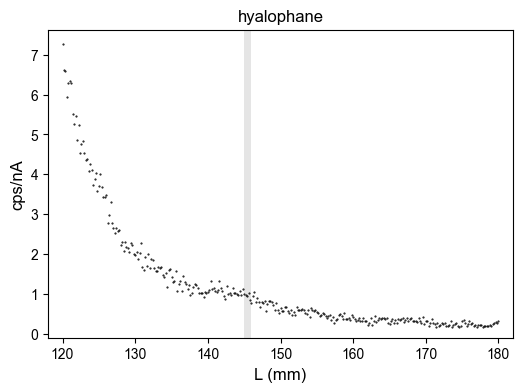

In [11]:
# ------#### INPUT #### -----------------------------
# Where is the data stored?
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/albite_22122021_0006_QLW/Pos_0001/')
# What's the sample name?
sample = 'hyalophane'
# Option to add peak position markers to plot:
pk_pos_markers =  [146.6] #
# ---------------------------------------------------
# Read in the data
comments, data = readfiles.import_jeol_wdscans(
    subfolder=Path("../data/raw/hyalophane_StA/wd_scans/hyalophane_22122021_0010_QLW/Pos_0002"),
    comment_line_num=80
)

# Plot the data without fitting
wdscan.plot_wdscan(comments, data, save_to="../data/interim/hyalophane_StA/wd_scan.png")

In [12]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,135], [155, 180]]

trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, pk_pos_markers, save_to=Path("../data/interim/hyalophane_StA/fits"))
par_dict = wdscan.write_fit_params(out, sample, save_to=Path("../data/interim/hyalophane_StA/fits/"))

### Quant analysis

In [13]:
samples = ['hyalophane_GaNcalib', 'hyalophane_BNcalib'] # List of samples in this dataset
sample_folders = [Path('../data/raw/hyalophane_StA/hyalophane_using_GaN_standard/'),
                  Path('../data/raw/hyalophane_StA/hyalophane_using_BN_standard/')] # List of folders corresponding to the samples
category = 'hyalophane' # Category of this dataset (e.g. "glasses")

wd_scan = Path('../data/interim/hyalophane_StA/fits/key_params_hyalophane.txt') # Path to wd scan fit parameters
std_dbase_info_file = Path('data/_dictionaries/standards.csv')

In [14]:
datalist = readfiles.find_files_and_folders(
                samples, sample_folders,
                apf_file=None,
                # apf_file=Path('../data/_dictionaries/apf_values.csv'), #<- Can put None in here
                wd_scan=wd_scan
                )

# add the apf values separately because these come from different files for the 
# different calibrations

datalist["apf"] = [0.819] * 5 + [0.96] * 5
datalist["apf_sd"] = [0.013] * 5 + [0.02] * 5

datalist

Comments found: ['hyalophane_50nA_20um_GaNcalibr_5', 'hyalophane_50nA_20um_GaNcalibr_6', 'hyalophane_50nA_20um_GaNcalibr_7', 'hyalophane_50nA_20um_GaNcalibr_8', 'hyalophane_50nA_20um_GaNcalibr_9']
Comments found: ['hyalophane_50nA_20um_BNcalibr_1', 'hyalophane_50nA_20um_BNcalibr_2', 'hyalophane_50nA_20um_BNcalibr_3', 'hyalophane_50nA_20um_BNcalibr_4', 'hyalophane_50nA_20um_BNcalibr_5']


,folder,comment,sample,paramfile,apf,apf_sd
0,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_5,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.819,0.013
1,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_6,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.819,0.013
2,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_7,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.819,0.013
3,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_8,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.819,0.013
4,..\data\raw\hyalophane_StA\hyalophane_using_Ga...,hyalophane_50nA_20um_GaNcalibr_9,hyalophane_GaNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.819,0.013
5,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_1,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.960,0.020
6,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_2,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.960,0.020
7,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_3,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.960,0.020
8,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_4,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.960,0.020
9,..\data\raw\hyalophane_StA\hyalophane_using_BN...,hyalophane_50nA_20um_BNcalibr_5,hyalophane_BNcalib,..\data\interim\hyalophane_StA\fits\key_params...,0.960,0.020


In [15]:
myspot = [None] * len(datalist.folder)

for i in range(len(datalist.folder)):
    peak, bg, standard, info = readfiles.read_and_organise_data(
                                    datalist.loc[i,:].copy(),
                                    bgi=False,
                                    save=False)
    myspot[i] = correct_quant.Spot()
    myspot[i].add_data(info, bg, peak, standard)
    myspot[i].add_wd_scan_params_from_file(wd_scan)
    print('Read dataset:', i + 1, 'of', len(datalist), ':',
          myspot[i].info.comment)
    myspot[i].comprehensify_data()


 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 1 of 10 : hyalophane_50nA_20um_GaNcalibr_5

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 2 of 10 : hyalophane_50nA_20um_GaNcalibr_6

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 3 of 10 : hyalophane_50nA_20um_GaNcalibr_7

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 4 of 10 : hyalophane_50nA_20um_GaNcalibr_8

 loading path: ..\data\interim\hyalophane_StA\fits\key_params_hyalophane.txt
{'sigma': 3.4795533289747755, 'center': 108.64078285619988}
Read dataset: 5 of 10 : hyalophane_50nA_20um_GaNcalibr_9

 loading path: ..\data\i

In [ ]:
correct_quant.process_datasets(
    myspot, 
    datalist, 
    num_mc_sims=100, 
    path_out=Path("../data/processed/hyalophane_StA/background_corrections/")
    )

Make figure showing background correction and montecarlo simulation for hyalophane

Next cell has modified code from Spot.correct_bg and Spot.correct_bg_mc method to make a prettier figure

monte-carlo loop 0 of 100
monte-carlo loop 50 of 100


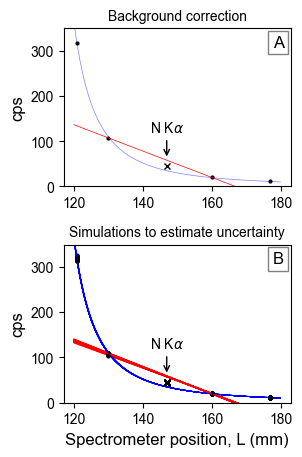

In [24]:
from scipy.stats import norm  # For monte carlo number generation
from src.correct_quant import compute_bg_positions, fit_quant_bg, lin_bg
import matplotlib.transforms as mtransforms
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = 10

def plot_background_correction(
        out, 
        pk_pos, 
        pk_cps,
        bg_pos, 
        bg_cps, 
        figure_axis=None,
        ):

    newx = np.arange(120.0, 180.0, 0.2)
    corrected_bg = out.eval(x=pk_pos)
    fitted = out.eval(x=newx)

    if figure_axis == None:
        plt.figure()
        ax = plt.axes()
    else:
        ax = figure_axis

    # Add the measured data
    plt.plot(bg_pos, bg_cps, 'ok', markersize=2)
    plt.plot(newx, fitted, '-b', linewidth=0.5, alpha=0.5)
    plt.plot(pk_pos, pk_cps, 'xk', linewidth=0.5)
    plt.plot(newx, lin_bg(newx, bg_cps[[0, 2]], bg_pos[[0, 2]]), '-r',
             linewidth=0.5)

    ylims = ax.get_ylim()
    plt.ylim(0, max(np.append(bg_cps, pk_cps)) +
             0.1 * max(np.append(bg_cps, pk_cps)))

    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    yrange = ylims[1] - ylims[0]
    xrange = xlims[1] - xlims[0]

    plt.xlabel('Spectrometer position, L (mm)')
    plt.ylabel('cps')

    return xlims, ylims



# Select spot of interest to use
spot = myspot[5]

fig = plt.figure(figsize=(8*0.39, 12*0.39))
mosaic = """A
            B"""
ax_dict = fig.subplot_mosaic(mosaic, sharex=False)

for label, ax in ax_dict.items():
    trans = mtransforms.ScaledTranslation(-5/72, -5/72, fig.dpi_scale_trans)
    ax.text(1.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=12, ha='right', va='top', fontfamily='Arial',
            bbox=dict(facecolor='w', edgecolor='grey', pad=3.0))

# === Normal background correction =====================================
plt.sca(ax_dict["A"])

idx = spot.idx_N[0]  # index of the element to be corrected
idx_dupl = spot.idx_N[1]  # index of the additional bg measurements

# Get background positions for N as a numpy array
bg_pos = compute_bg_positions(spot)

# Get background cps values as a numpy array
lwr_bg_cps = np.array(spot.bg.lwr_cps[idx:idx_dupl + 1])
upr_bg_cps = np.array(spot.bg.upr_cps[idx:idx_dupl + 1])
bg_cps = np.concatenate((lwr_bg_cps, upr_bg_cps), axis=0)

# Fit the background according to its shape
modelout = fit_quant_bg(bg_pos, bg_cps, spot.wd_scan_params)

# Find the corrected background cps
corrected_bg = modelout.eval(x=spot.peak.pos[idx])
pk_cps_corrected = spot.peak.raw_cps[idx] - corrected_bg

plot_background_correction(
        modelout, spot.peak.pos[idx], spot.peak.raw_cps[idx], bg_pos,
        bg_cps, figure_axis=ax_dict["A"])

# === Monte Carlo background correction =====================================
plt.sca(ax_dict["B"])

num_mc_sims = 100

idx = spot.idx_N[0]
idx_dupl = spot.idx_N[1]

# Create an array with rows being a mc-simulation of the peak cps
pk_cps_raw = norm.rvs(loc=spot.peak.raw_cps[idx],
                        scale=spot.peak.stdev_raw_cps[idx],
                        size=num_mc_sims, random_state=None)

# Get background positions based on relative position from peak
bg_pos = compute_bg_positions(spot)

# Get background cps values and stdevs
lwr_bg_cps = np.array(spot.bg.lwr_cps[idx:idx_dupl + 1])
upr_bg_cps = np.array(spot.bg.upr_cps[idx:idx_dupl + 1])
bg_cps_means = np.concatenate((lwr_bg_cps, upr_bg_cps), axis=0)

lwr_bg_stdev = np.array(spot.bg.stdev_lwr[idx:idx_dupl + 1])
upr_bg_stdev = np.array(spot.bg.stdev_upr[idx:idx_dupl + 1])
bg_cps_stdev = np.concatenate((lwr_bg_stdev, upr_bg_stdev), axis=0)

# Create a matrix with rows being mc-simulations of the background
bg_cps = np.empty(shape=(num_mc_sims, 4))

for i in range(4):
    bg_cps[:, i] = norm.rvs(loc=bg_cps_means[i],
                            scale=bg_cps_stdev[i],
                            size=num_mc_sims, random_state=None)

pk_cps_net_corrected = np.empty(shape=(num_mc_sims, 1))
bg_cps_corrected = np.empty(shape=(num_mc_sims, 1))

# Perform the background fits and plot a figure at the same time
fit_params_mc = [None] * num_mc_sims

for i in range(num_mc_sims):
    # Fit the background according to its shape

    # Print a loop counter
    if i % 50 == 0: # If i is divisible by 50
        print('monte-carlo loop {} of {}'.format(i, num_mc_sims))

    modelout = fit_quant_bg(bg_pos, bg_cps[i, :], spot.wd_scan_params)

    fit_params_mc[i] = [modelout.params['amplitude'].value,
                        modelout.params['c'].value]

    # Find the corrected background cps
    bg_cps_corrected[i] = modelout.eval(x=spot.peak.pos[idx])
    pk_cps_net_corrected[i] = pk_cps_raw[i] - bg_cps_corrected[i]

    # Add this to the figure
    xlims, ylims = plot_background_correction(
        modelout, spot.peak.pos[idx], pk_cps_raw[i], bg_pos,
        bg_cps[i, :], figure_axis=ax_dict["B"])

mean_from_mc = [np.mean(pk_cps_net_corrected), np.mean(bg_cps_corrected)]
stdev_pcnt_from_mc = [np.std(pk_cps_net_corrected) * 100 / mean_from_mc[0],
                        np.std(bg_cps_corrected) * 100 / mean_from_mc[1]]

for k in ax_dict.keys():

    ax_dict[k].annotate(
        text=r"N K$\alpha$",
        xy=(146.893, 60),
        xytext=(146.893, 120),
        ha="center",
        arrowprops={"arrowstyle": "->"}
    )

ax_dict["A"].set_title("Background correction", fontsize=10)
ax_dict["B"].set_title("Simulations to estimate uncertainty", fontsize=10)
ax_dict["A"].set_xlabel(None)


plt.tight_layout()
plt.savefig("../figures/fig_hyalophane_bg_correction_and_mc_simulation.png", dpi=600)
plt.show()


In [ ]:
summary_tables = correct_quant.write_summary_excel_tables(
    myspot, 
    "../data/processed/hyalophane_StA/kraw_summaries.xlsx"
    )

### Compile the typical k-ratio values with different levels of correction

In [ ]:
typical_kratios = pd.DataFrame({
    "K-ratio": [
        summary_tables[0]["original.kraw_pcnt"].mean(),
        summary_tables[0]["montecarlo.kraw_pcnt"].mean(),
        summary_tables[0]["montecarlo.kraw_apf_pcnt"].mean()
    ],
    "Stdev % (relative)": [
        max(
            summary_tables[0]["original.kraw_stdev_pcnt"].mean(),
            summary_tables[0]["original.kraw_pcnt"].std()
            ),
        max(
            summary_tables[0]["montecarlo.kraw_stdev_pcnt"].mean(),
            summary_tables[0]["montecarlo.kraw_pcnt"].std()
            ),
        max(
            summary_tables[0]["montecarlo.kraw_stdev_apf_pcnt"].mean(),
            summary_tables[0]["montecarlo.kraw_apf_pcnt"].std()
            )
    ]
}, index = [
    "Original K-ratio (%)", 
    "Bg-corrected K-ratio (%)", 
    "Bg- and APF-corrected K-ratio (%)"
    ]
)

typical_kratios.insert(
    1, 
    column="Stdev (absolute)", 
    value = typical_kratios["K-ratio"] * typical_kratios["Stdev % (relative)"] / 100
    )

typical_kratios

## Write calczaf file

In [ ]:
samples = ['hyalophane_GaNcalib', 'hyalophane_BNcalib'] # List of samples in this dataset
category = 'hyalophane'
subfolder = Path('../data/processed/hyalophane_StA/calczaf_files/')

write_detection_limit_calczaf_files = True
detlim_subfolder = Path('../data/processed/hyalophane_StA/calczaf_files/detlim/')

# note: in the subfolder there must be a file specifying valence.
# this can be copied from the _dictionaries folder.
valence_dict = readfiles.read_valence_file(subfolder, pattern='valence*')
standard_database_dict = pd.read_csv(
    '../data/_dictionaries/standards.csv',
     index_col=0, 
     header=None, 
     squeeze=True).to_dict()

standard_database_dict

In [ ]:
# Make a dictionary
sampledata = [None]*len(samples)
for i, sample in enumerate(samples):
    sampledata[i] = [spot for i, spot in enumerate(myspot) if sample == spot.info['sample']]

sampledata = dict(zip(samples,sampledata))

In [ ]:
hyal_literature_vals = pd.Series(dict(
    {"Si": 23.25,
     "Al": 11.65,
     "K":  5.68,
     "Na": 1.11,
     "Ba": 17.42,
     "Sr": 0.29}
))
hyal_literature_vals


# Or use actual analyses from StA

hyal_element_vals = hyal_majors_summary.loc[["Si", "Al", "Sr", "Fe", "K", "Ba", "Na"], "wt% mean"]

In [ ]:
# For multiple different methods of processing the data, add a description
run_descriptor = ['_1_base', '_2_bg', '_3_bg_apf']  
# Leave as a list of an empty string if not using: e.g. run_descriptor = ['']

for i in range(len(samples)):

    # Here we pass in these arguments as a dictionary - this is useful in order
    # to reuse the arguments for the detection limit function. But you can
    # alternatively pass in each argument just by defining it in the function
    # as normal (see glasses example).

    args = {
              'elementByDifference' : None # string element symbol
            , 'elementByStoichToStoichOxygen' : None # string element symbol
            , 'stoichOxygenRatio' : 0
            # for hyalophane there is H
            # that can be defined stoichiometrically relative to N:
            , 'elementByStoichToOtherElement' : 'h'
            , 'OtherElement' : 'n'
            , 'stoichElementRatio' : 4

            , 'correct_bg' : False
            , 'correct_apf' : False

            # Elements to omit from matrix correction
            # (e.g. if analysed but not actually present in sample)
            , 'remove_elements' : None

            , 'definedElements' : hyal_element_vals.index # list of element symbols to add
            , 'definedElementWts' : hyal_element_vals.values # list of known element wt% to add
            }
    
    # Make copies of args with different values
    args2 = args.copy()
    args2["correct_bg"] = True
    args2["correct_apf"] = False

    args3 = args2.copy()
    args3["correct_bg"] = True
    args3["correct_apf"] = True

    args_list = [args, args2, args3]

    for j in range(len(run_descriptor)):
        print("******************************************************")
        print(args_list[j]["correct_bg"], args_list[j]["correct_apf"])
        print("******************************************************")

        calczaf_path_out = subfolder / '{}{}.dat'.format(
                                            samples[i], run_descriptor[j])
        open(calczaf_path_out, 'w').close()  # Erase contents of file

        if write_detection_limit_calczaf_files:
            
            detlim_path_out = detlim_subfolder / '{}{}_detlim.dat'.format(
                                            samples[i], run_descriptor[j])
            open(detlim_path_out, 'w').close()  # Erase contents of file

        for spot in sampledata[samples[i]]:

            calczaf.write_calczaf_input(
                spot, calczaf_path_out, valence_dict, standard_database_dict,
                accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                **args_list[j]) # <- **args unpacks the args dictionary defined earlier
                # so that all those arguments are passed into the function
                # without the need to type them all out.

            if write_detection_limit_calczaf_files:
                if args_list[j]['correct_bg']:

                    detlim_spot = correct_quant.create_detection_limit_spot(spot)

                    calczaf.write_calczaf_input(
                        detlim_spot, detlim_path_out, valence_dict, 
                        standard_database_dict,
                        accV=10, calcMode=2, taAngle=40, Oxide_or_Element=1,
                        **args_list[j])
                    
                else:
                    print('\n\nWarning: Not writing detection limit file.' 
                            'Calculating detection limit does not make sense'
                            ' except on background-corrected data. Raw data files' 
                            ' contain an estimate of detection limit without bg'
                            ' correction.\n')
                    
    

Manual step - run through calczaf

## Calczaf results

In [ ]:
folderpath = Path('../data/processed/hyalophane_StA/calczaf_files/')

helper_funs.check_calczaf_folder_exists(folderpath)
valence_file = sorted(folderpath.glob('valence*'))[0]

results = calczaf.process_calczaf_outputs(folderpath, valence_file)

# For detection limits

results_detlim = calczaf.process_calczaf_outputs(folderpath / 'detlim/', valence_file, detlim=True)

In [ ]:
wt_pct_summary_table = pd.concat(
    {k: v[["average", "stdev"]] for k, v in results["wtdata"].items()},
    axis=1
    ).round(2)

wt_pct_summary_table.to_csv("../data/processed/hyalophane_StA/wt_pct_summary.csv")

wt_pct_summary_table


### Compile a summary of nitrogen with stdevs on both individual and multiple measurements

In [ ]:
suffix_list = ["1_base", "2_bg", "3_bg_apf"]

summary, details = compile_n_summary(
    suffix_list, results, results_detlim, sampledata, datalist, summary_tables, samples
)

summary


In [ ]:
summary.to_csv("../data/processed/hyalophane_StA/N_summary.csv")

### Investigate effect of blank correction

For comparison with albite below, check out the raw cps and the magnitude of the bg correction

In [ ]:
bg_at_peak_pos = [s.montecarlo.loc[0, "bg_cps_mc_mean"] for s in myspot]
print("Bg cps at peak position: {:.1f}".format(np.mean(bg_at_peak_pos)))
print(
    "Stdev of multiple measurements of bg cps: {:.1f}".format(
    np.mean(np.std(bg_at_peak_pos))
    )
)
print(
    "Typical stdev on bg cps, "
    "computed using montecarlo approach: "
    "relative = {:.1f} %, absolute = {:.1f}".format(
    np.mean([s.montecarlo.loc[0, "bg_cps_mc_stdev_pcnt"] for s in myspot]),
    np.mean([s.montecarlo.loc[0, "bg_cps_mc_mean"] * s.montecarlo.loc[0, "bg_cps_mc_stdev_pcnt"]/100 for s in myspot])
    )
)


In [ ]:
raw_cps = [s.peak.loc[0, "raw_cps"] for s in myspot]

print(np.mean(raw_cps))
(np.std(raw_cps))

# Albite wavelength scan

In [ ]:
# ------#### INPUT #### -----------------------------
# Where is the data stored?
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/albite_22122021_0006_QLW/Pos_0001/')
# What's the sample name?
sample = 'albite'
# Option to add peak position markers to plot:
# e.g. pk_pos_markers = False (no markers)
#      pk_pos_markers = [145.839] (one marker)
#      pk_pos_markers = [145.84, 145.73] (two markers)
pk_pos_markers =  [145.839] #
# ---------------------------------------------------

In [ ]:
# Read in the data
comments, data = readfiles.import_jeol_wdscans(
    subfolder=scan_path)

# Plot the data without fitting
wdscan.plot_wdscan(comments, data, save_to=None)

In [ ]:
# Fit and plot with the fits ------------
# Choose parts of the spectrum to use in the fit
bg_roi = [[120,180]]

trimmed_data = wdscan.trim_data_from_regions(data, bg_roi)
out = wdscan.fit_bg(trimmed_data)
wdscan.plot_bg_fit(data, trimmed_data, out, sample, pk_pos_markers, save_to=None)
par_dict = wdscan.write_fit_params(out, sample, save_to=None)

# Overlay hyalophane and albite wavelength scans

In [ ]:
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/hyalophane_22122021_0010_QLW/Pos_0002/')
_, hyal_data = readfiles.import_jeol_wdscans(
    subfolder=scan_path)
scan_path = Path('../data/raw/hyalophane_StA/wd_scans/albite_22122021_0006_QLW/Pos_0001/')
_, albite_data = readfiles.import_jeol_wdscans(
    subfolder=scan_path)

fig, ax = plt.subplots()

plt.scatter(albite_data.L, albite_data.cps_per_nA, marker='.', color='k', s=10, label="Albite")
plt.scatter(hyal_data.L, hyal_data.cps_per_nA, marker='.', color='r', s=10, label="Hyalophane")
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([100.0])

ylims = ax.get_ylim()
plt.ylim(-0.1, ylims[1])

pk_pos = [146.4, 146.8]

plt.fill_between([pk_pos[0], pk_pos[1], pk_pos[1], pk_pos[0]],
                    [-0.1, -0.1, ylims[1], ylims[1]], alpha=0.2, color='grey',
                    linewidth=0)

plt.xlabel('L (mm)')

plt.ylabel('cps/nA')
plt.xlim(118, 182)

# Albite quant analyses 

The point of an albite quant analysis was that if you measure on peak, you can use that value as a background for hyalophane. In principle...

Admittedly, albite doesn't have 17 wt% Ba though

In [ ]:
samples = ['albite'] # List of samples in this dataset
sample_folders = [Path('../data/raw/hyalophane_StA/albite_quant/')] # List of folders corresponding to the samples
category = 'albite' # Category of this dataset (e.g. "glasses")

wd_scan = Path('data/interim/buddingtonite_ANU/fits/key_params_buddingtonite.txt') # Path to wd scan fit parameters
std_dbase_info_file = Path('data/_dictionaries/standards.csv')

In [ ]:
datalist = readfiles.find_files_and_folders(
                samples, sample_folders,
                # apf_file=Path('data/_dictionaries/apf_values.csv'), #<- Can put None in here
                # wd_scan=wd_scan
                )

datalist

In [ ]:
myspot = [None] * len(datalist.folder)

for i in range(len(datalist.folder)):
    peak, bg, standard, info = readfiles.read_and_organise_data(
                                    datalist.loc[i,:].copy(),
                                    bgi=False,
                                    save=False)
    myspot[i] = correct_quant.Spot()
    myspot[i].add_data(info, bg, peak, standard)
#   myspot[i].add_wd_scan_params_from_file(wd_scan)
    print('Read dataset:', i + 1, 'of', len(datalist), ':',
          myspot[i].info.comment)
    myspot[i].comprehensify_data()

In [ ]:
myspot[0].peak

In [ ]:
myspot[0].standard

Okay, so I only analysed nitrogen in this albite. 

I have five analyses for which all have raw cps values. 

So I can use these raw cps values (at the peak position) to correct the raw cps values for hyalophane as an alternative to the background correction method.

In [ ]:
[s.peak.loc[0, "raw_cps"] for s in myspot]

That's the raw cps. 

In [ ]:
print(np.mean([s.peak.loc[0, "raw_cps"] for s in myspot]))
(np.std([s.peak.loc[0, "raw_cps"] for s in myspot]))

So the typical raw cps in those albite analyses was 33.1(2)

In contrast, from above, the typical background correction using the montecarlo background fitting approach on hyalophane directly was 35.0(3) (stdev on multiple measurements; this was larger than stdev on individual measurements).

So....
this means that on average if we used the albite as a background correction for hyalophane, we would gain two cps on the net background counts, given that these were about 10, this is an increase of about 20%

So we could expect the N concentrations to be about 20% larger if we did this.